In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from PIL import Image

In [2]:
import requests

class Kuzushijidataset():
    
    resources = [
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz"),
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz"),
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz"),
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz")]
    
    training_file_imgs = "k49-train-imgs.npz"
    training_file_labels = "k49-train-labels.npz"
    test_file_imgs = "k49-test-imgs.npz"
    test_file_labels = "k49-test-labels.npz"
    data_dir = "data"
    
   
    def __init__(self, data_dir="data", train=True, transform=None, download=True):
        self.data_dir = data_dir
        
        if download:
            self.download(train)
            
        train_data_imgs = os.path.join(self.data_dir, self.training_file_imgs)
        train_data_imgs = np.load(train_data_imgs)
        train_data_imgs = train_data_imgs.f.arr_0

        train_data_labels = os.path.join(self.data_dir, self.training_file_labels)
        train_data_labels = np.load(train_data_labels)
        train_data_labels = train_data_labels.f.arr_0

        test_data_imgs = os.path.join(self.data_dir, self.test_file_imgs)
        test_data_imgs = np.load(test_data_imgs)
        test_data_imgs = test_data_imgs.f.arr_0
        
        test_data_labels = os.path.join(self.data_dir, self.test_file_labels)
        test_data_labels = np.load(test_data_labels)
        test_data_labels = test_data_labels.f.arr_0
        
        self.transform = transform
        
        if train:
            self.data = train_data_imgs
            self.targets = train_data_labels
        else:
            self.data = test_data_imgs
            self.targets = test_data_labels


    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.targets[idx])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img, mode='L') # mode='L' - (8-bit pixels, black and white)

        if self.transform:
            img = self.transform(img)
        
        return img, target        
      
    def download(self, train):
        # download the Kuzushiji-49 dataset if it doesn't exist
        if self._check_exists():
            if train:
                print('Train dataset already exists!')
            else:
                print('Test dataset already exists!')
            return

        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
        for url in self.resources:
            filename = url.rpartition('/')[2]
            print('Downloading: ', filename)
            myfile = requests.get(url, allow_redirects=True)
            open(os.path.join(self.data_dir, filename), 'wb').write(myfile.content)

        print('All files downloaded!')
        

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.data_dir, self.training_file_imgs)) and
                os.path.exists(os.path.join(self.data_dir, self.training_file_labels)) and
                os.path.exists(os.path.join(self.data_dir, self.test_file_imgs)) and
                os.path.exists(os.path.join(self.data_dir, self.test_file_labels)))


In [3]:
classes = ['あ - a', 'い - i', 'う - u', 'え - e', 'お - o', 
       'か - ka', 'き - ki', 'く - ku', 'け - ke', 'こ - ko', 
       'さ - sa', 'し - shi', 'す - su', 'せ - se', 'そ - so', 
       'た - ta', 'ち - chi', 'つ - tsu', 'て - te', 'と - to', 
       'な - na', 'に - ni', 'ぬ - nu', 'ね - ne', 'の - no',
       'は - ha', 'ひ - hi', 'ふ - fu', 'へ - he', 'ほ - ho',
       'ま - ma', 'み - mi', 'む - mu', 'め - me', 'も - mo',
       'や - ya', 'ゆ - yu', 'よ - yo', 
       'ら - ra', 'り - ri', 'る - ru', 'れ - re', 'ろ - ro',
       'わ - wa', 'ゐ - wi', 'ゑ - we', 'を - wo', 'ん - n', 'ゝ']

In [4]:
# Load train and test datasets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
    ])


train_data = Kuzushijidataset("data", train=True, download=True, transform=transforms.ToTensor())

test_data = Kuzushijidataset("data", train=False, download=True, transform=transforms.ToTensor())


print("Train dataset size: ", len(train_data))
print("Test dataset size: ", len(test_data))

Downloading:  k49-train-imgs.npz
Downloading:  k49-train-labels.npz
Downloading:  k49-test-imgs.npz
Downloading:  k49-test-labels.npz
All files downloaded!
Test dataset already exists!
Train dataset size:  232365
Test dataset size:  38547


In [5]:
# Split the training dataset into training and validation
train_data, val_data = torch.utils.data.random_split(train_data, [210000, 22365])    # split into 200k training & ~32k validation (roughly the size of the test dataset)

In [6]:
batch_size = 128

# create training data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 


# create validation data loader
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

# create test data loader
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


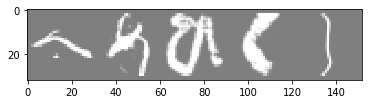

へ - he | め - me | ひ - hi |     ゝ | し - shi |


In [7]:
import matplotlib.pyplot as plt
import numpy as np

qtd_images = 5

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:qtd_images], nrow = qtd_images, scale_each=False))
# print labels
print(' '.join('%5s |' % classes[labels[j]] for j in range(qtd_images)))

In [8]:
# define the model

import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
            # torch.nn.conv2d(in_channels, out_channels, kernel_size)
            # in_channels is the number of layers which it takes in (i.e.num color channels in 1st layer)
            # out_channels is the number of different filters that we use
            # kernel_size is the depthxwidthxheight of the kernel#
            # stride is how many pixels we shift the kernel by each time
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1), # -4
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=5, stride=1),#
            torch.nn.ReLU()
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(64 * 20 * 20, 120),
            torch.nn.Linear(120, 49)
        )
        
        # Spatial transformer localization-network
        self.localization = torch.torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=7),
            torch.nn.MaxPool2d(2, stride=2),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 10, kernel_size=5),
            torch.nn.MaxPool2d(2, stride=2),
            torch.nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = torch.nn.Sequential(
            torch.nn.Linear(10 * 3 * 3, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
    
    def forward(self, x):
        x = self.stn(x)
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_layers(x)
        X = F.softmax(x, dim=1)
        return x


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda)

True


In [10]:
CNN = ConvNet().to(device)

criterion = torch.nn.CrossEntropyLoss()

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [11]:
def train(model, epochs, optimiser='Adam', learning_rate = 0.0001, verbose=False, tag='Loss/Train'):
    if(optimiser=='Adam'):
        optimiser = torch.optim.Adam(model.parameters(), lr= learning_rate)
    else:
        optimiser = torch.optim.SGD(model.parameters(), lr= learning_rate)
        
    
    model.train()                                  # put the model into training mode (more on this later)
    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            prediction = model(inputs) # pass the data forward through the model
            loss = criterion(prediction, labels) # compute the loss
            optimiser.zero_grad() # reset the gradients attribute of each of the model's params to zero
            loss.backward() # backward pass to compute and set all of the model param's gradients
            optimiser.step() # update the model's parameters
            writer.add_scalar(tag, loss, epoch*len(train_loader) + idx)    # write loss to a graph
        if verbose: print('Epoch:', epoch, '\tAccuracy:', calc_accuracy(model, val_loader), '\tLoss:', loss)

In [12]:
import numpy as np
            
def calc_accuracy(model, dataloader, testset=False):
    misclass_i = []
    misclass_l = []
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))

        if testset: #generate a list of misclassified data
            if sum(predictions != labels):
                for i in range(len(predictions)):
                    if(predictions[i] != labels[i]):
                        misclass_i.append(inputs[i])
                        misclass_l.append(labels[i])
                
    percent_correct = num_correct / num_examples * 100
    return percent_correct, misclass_i, misclass_l

In [ ]:
model = CNN

train(model, epochs=8, optimiser='Adam', learning_rate=0.0001, verbose=True)
print('Train Accuracy:', calc_accuracy(model, train_loader))
print('Test Accuracy:', calc_accuracy(model, test_loader))

/home/elisio/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/elisio/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Epoch: 0 	Accuracy: (87.89179521573888, [], []) 	Loss: tensor(0.1699, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 1 	Accuracy: (91.11558238318803, [], []) 	Loss: tensor(0.3328, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 2 	Accuracy: (92.96668902302704, [], []) 	Loss: tensor(0.1340, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 3 	Accuracy: (93.83858707802369, [], []) 	Loss: tensor(0.3004, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 4 	Accuracy: (94.12027721886876, [], []) 	Loss: tensor(0.2140, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 5 	Accuracy: (94.6121171473284, [], []) 	Loss: tensor(0.1478, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 6 	Accuracy: (94.77755421417393, [], []) 	Loss: tensor(0.0521, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 7 	Accuracy: (94.87145092778896, [], []) 	Loss: tensor(0.0781, device='cuda:0', grad_fn=<NllLossBackward>)
Train Accuracy: (97.55142857142857, [], [])
